Single qubit errors
===============

This is a simulation of single qubit errors in qiskit to confirm our understanding of the depolarising and measurement noise model.  

In the depolarising error channel in quiskit the parameter p implies a probability p that a completely mixed state is swapped in.  When this state is measured with probability p/2 it will no longer be in the ground state.  

This was checked by applying the noise model to sequential X, Y, Z, H, S and SDG gates, measuring the result, and comparing with a calculation. 

This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

Import the necessary function modules.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

Define constants so the process flow can be controlled from one place:

In [2]:
SHOTS = 10000                            #Number of shots to run 
MEASURE_NOISE = 0.01                     #Measurement noise
SINGLE_GATE_DEPOLARISING = 0.000366      #Single gate depolarising.    
NOISE = True                             #Test with noise
GATE_DEPTH = 16
LIST_QUBIT_TYPES = ['x','y','z','h','s','sdg']

SIMULATOR = Aer.get_backend('qasm_simulator')

Define the noise model

In [3]:
def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ['x', 'y', 'z', 'h', 's', 'sdg'])  # single qubit gate errors

    return noise_model

We calculate the expected number of measurements in the ground state recalling that with probabilily SINGLE_GATE_DEPOLARISING / 2 the gate will no longer be in the ground state. 

In [4]:
expected = (SHOTS * (1 - SINGLE_GATE_DEPOLARISING /2 ) ** GATE_DEPTH) * (1 - MEASURE_NOISE)

For each qubit type we find the error.

In [5]:
print(f'With {SHOTS} shots we expect to see {expected:.0f} measurements of the |0> ground state .')

for qubit_type in LIST_QUBIT_TYPES:
    qr = QuantumRegister(1,'code_qubit')     # One qubit
    cr = ClassicalRegister(1,'syndrome_bit') # One Syndrome bit
    qc = QuantumCircuit(qr,cr)
    
    for i in range(GATE_DEPTH):
        if qubit_type == 'x':
            qc.x(qr[0])
        elif qubit_type == 'y':
            qc.y(qr[0])
        elif qubit_type == 'z':  
            qc.z(qr[0])
        elif qubit_type == 'h': 
            qc.h(qr[0])
        elif qubit_type == 's':  
            qc.s(qr[0])
        elif qubit_type == 'sdg': 
            qc.sdg(qr[0])
        else:
            raise Exception("Unexpected qubit type in list")
    qc.measure(qr, cr)
    
    #initialise circuit
    noise_model = get_noise(MEASURE_NOISE,SINGLE_GATE_DEPOLARISING)
    if NOISE:
        result = execute(qc, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
    else:
        result = execute(qc, SIMULATOR, shots=SHOTS).result()     
    counts = result.get_counts(qc)
    print(f'With the {qubit_type} gate the simulated measurements in the ground state were {counts}')

With 10000 shots we expect to see 9871 measurements of the |0> ground state .
With the x gate the simulated measurements in the ground state were {'0': 9857, '1': 143}
With the y gate the simulated measurements in the ground state were {'0': 9868, '1': 132}
With the z gate the simulated measurements in the ground state were {'0': 9875, '1': 125}
With the h gate the simulated measurements in the ground state were {'0': 9868, '1': 132}
With the s gate the simulated measurements in the ground state were {'0': 9889, '1': 111}
With the sdg gate the simulated measurements in the ground state were {'0': 9863, '1': 137}


 An example circuit is shown below.

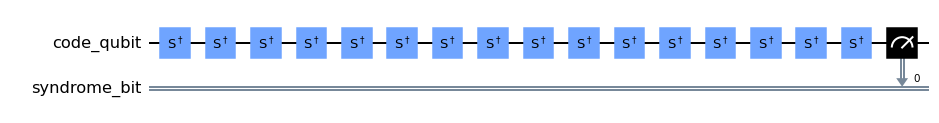

In [6]:
qc.draw(output='mpl')